In [50]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [51]:
data_dir = '../input/cleanDataset/'


In [52]:
# review number of files and directories in the dataset
total_dir = len(os.listdir(data_dir))
total_files = 0

for dirname, _, filenames in os.walk(data_dir):
    print('counting:', dirname)
    files_counter = 0
    for file in filenames:
        files_counter += 1
    total_files += files_counter
    print('total files in dir:', files_counter)

print('--------')
print('total number of files',total_files)
print('total number of directories',total_dir)

counting: ../input/cleanDataset/
total files in dir: 1
counting: ../input/cleanDataset/paper
total files in dir: 594
counting: ../input/cleanDataset/metal
total files in dir: 410
counting: ../input/cleanDataset/cardboard
total files in dir: 403
counting: ../input/cleanDataset/trash
total files in dir: 137
counting: ../input/cleanDataset/glass
total files in dir: 501
counting: ../input/cleanDataset/plastic
total files in dir: 482
--------
total number of files 2528
total number of directories 7


In [53]:
# create datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=100
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=100
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [54]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


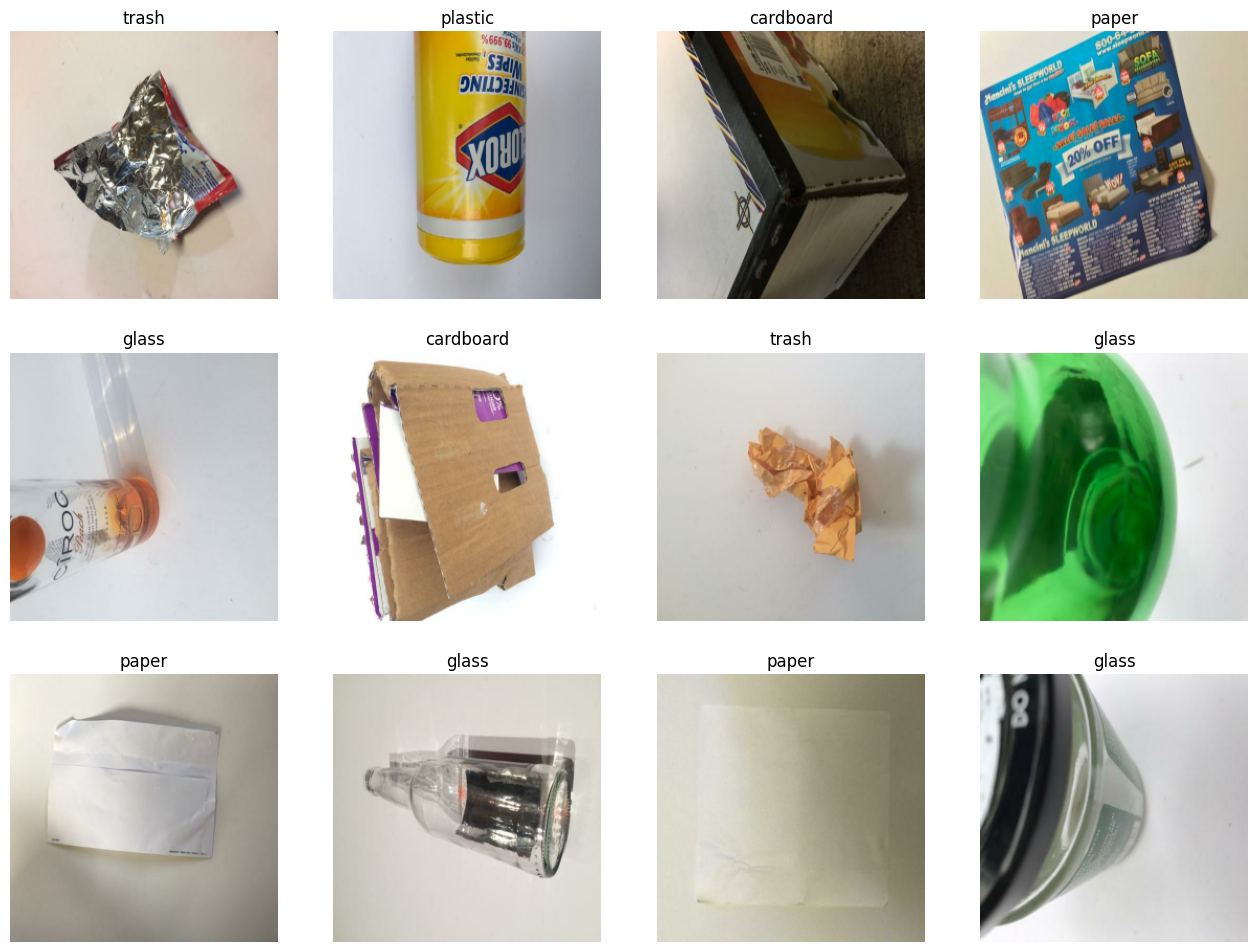

In [55]:
plt.figure(figsize=(16, 16))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

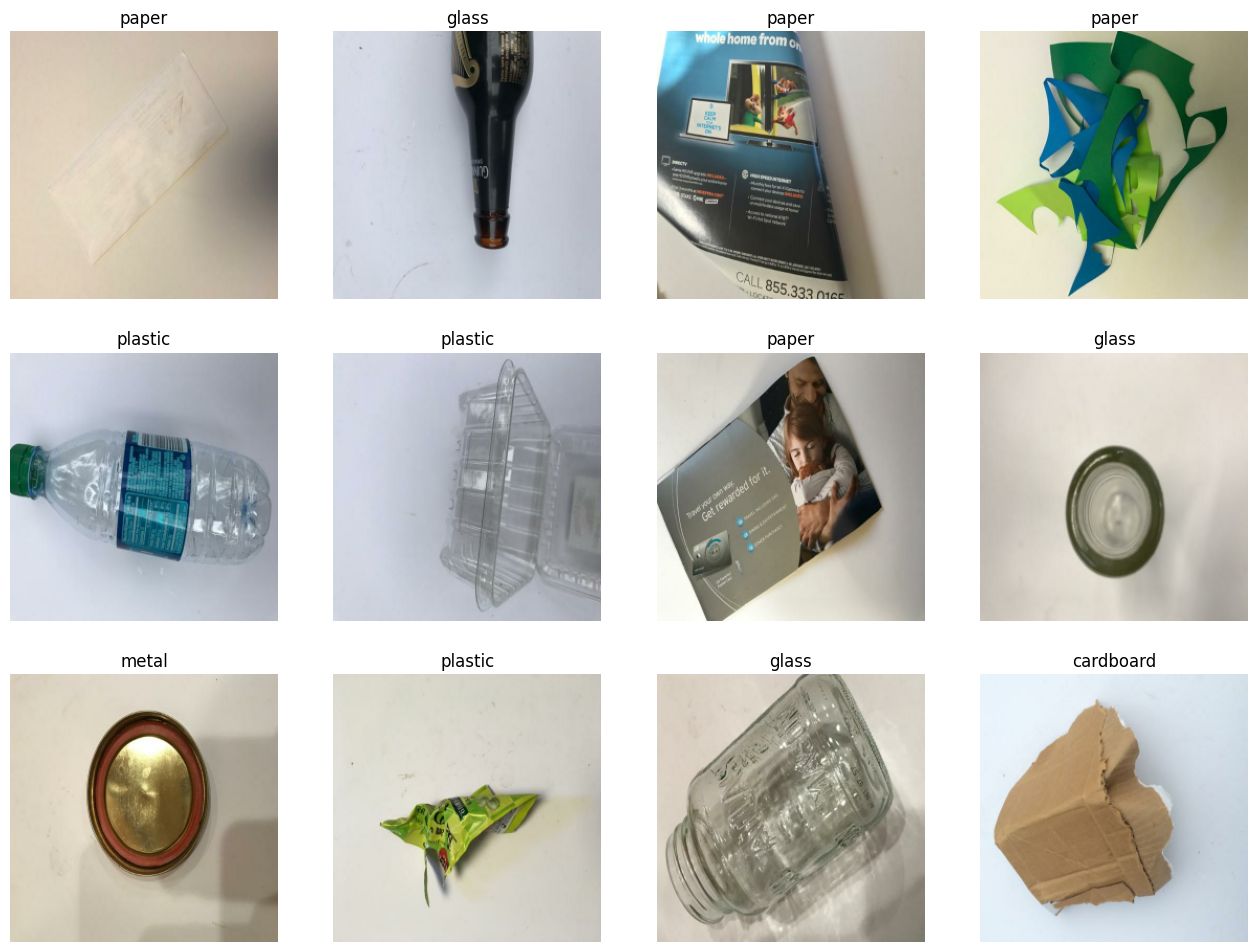

In [56]:
# view some images from the validation_ds
plt.figure(figsize=(16, 16))
for images, labels in validation_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [57]:
# inspect the train_ds
train_batch = train_ds.as_numpy_iterator().next()

print('total of batches:',len(train_ds))
print('images batch shape:',train_batch[0].shape)
print('labels batch shape:',train_batch[1].shape)

total of batches: 64
images batch shape: (32, 256, 256, 3)
labels batch shape: (32,)


In [58]:
# inspect the validation_ds
validation_batch = validation_ds.as_numpy_iterator().next()

print('total of batches:',len(validation_ds))
print('images batch shape:',validation_batch[0].shape)
print('labels batch shape:',validation_batch[1].shape)

total of batches: 16
images batch shape: (32, 256, 256, 3)
labels batch shape: (32,)


In [59]:
# instantiate the base model
input_shape = (256,256,3)
base_model = tf.keras.applications.ResNet50V2(include_top=False, input_shape=input_shape)

# make the layers of the model trainable to fine-tunning
base_model.trainable = True

In [60]:
# review the base model architecture
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 130, 130, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

In [61]:
# find the tunning layer and its index
tuning_layer_name = 'conv5_block1_preact_bn'
tuning_layer = base_model.get_layer(tuning_layer_name)
tuning_index = base_model.layers.index(tuning_layer)

# freeze all the layers before the tuning layer
for layer in base_model.layers[:tuning_index]:
    layer.trainable =  False

In [62]:
# Créer une étape d'augmentation de données avec des retournements horizontaux et verticaux, des rotations et des zooms
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./127.5, offset= -1), 
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
], name='data_augmentation')

# Créer le modèle de réseau neuronal
model = tf.keras.Sequential([
    data_augmentation,
    # tf.keras.layers.Input(shape=input_shape),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(6, activation='softmax')
])

# Définir le taux d'apprentissage
learning_rate = 0.00001

# Compiler le modèle avec l'optimiseur Adam en spécifiant le taux d'apprentissage
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),  # Spécifier learning_rate ici
    metrics=['accuracy']
)

In [63]:
# train the model
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=7
)

Epoch 1/7
64/64 [==============================] - 104s 2s/step - loss: 1.6901 - accuracy: 0.3363 - val_loss: 1.2701 - val_accuracy: 0.5267
Epoch 2/7
64/64 [==============================] - 101s 2s/step - loss: 1.1621 - accuracy: 0.6009 - val_loss: 0.9339 - val_accuracy: 0.6653
Epoch 3/7
64/64 [==============================] - 101s 2s/step - loss: 0.9285 - accuracy: 0.6889 - val_loss: 0.7689 - val_accuracy: 0.7248
Epoch 4/7
64/64 [==============================] - 100s 2s/step - loss: 0.7748 - accuracy: 0.7473 - val_loss: 0.6673 - val_accuracy: 0.7743
Epoch 5/7
64/64 [==============================] - 100s 2s/step - loss: 0.6742 - accuracy: 0.7809 - val_loss: 0.5984 - val_accuracy: 0.7861
Epoch 6/7
64/64 [==============================] - 100s 2s/step - loss: 0.5955 - accuracy: 0.8042 - val_loss: 0.5435 - val_accuracy: 0.8119
Epoch 7/7
64/64 [==============================] - 100s 2s/step - loss: 0.5173 - accuracy: 0.8427 - val_loss: 0.5059 - val_accuracy: 0.8297


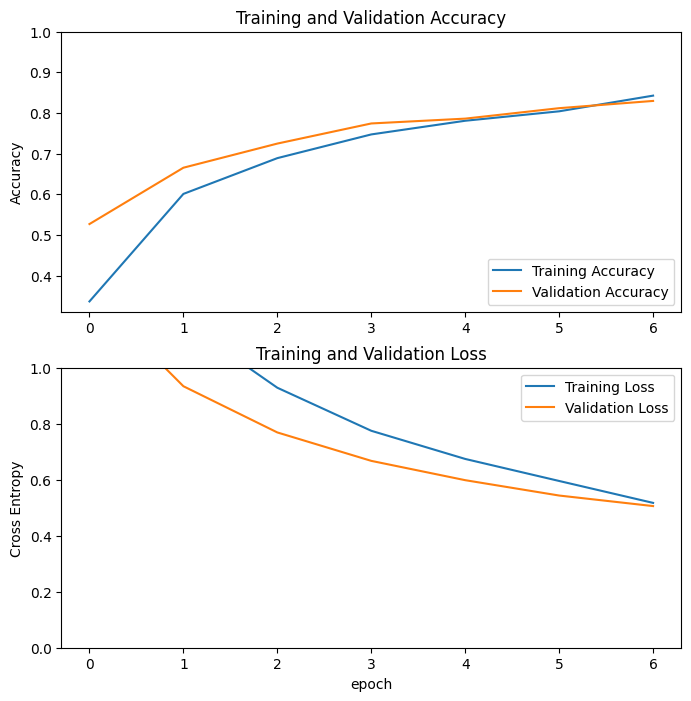

In [64]:
# visualize the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# plot accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# plot loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [65]:
# verify the performance of the model
loss, accuracy = model.evaluate(validation_ds)
print('Test accuracy :', accuracy)
print('Test loss:', loss)

16/16 [==============================] - 13s 802ms/step - loss: 0.5059 - accuracy: 0.8297
Test accuracy : 0.8297029733657837
Test loss: 0.5058649182319641


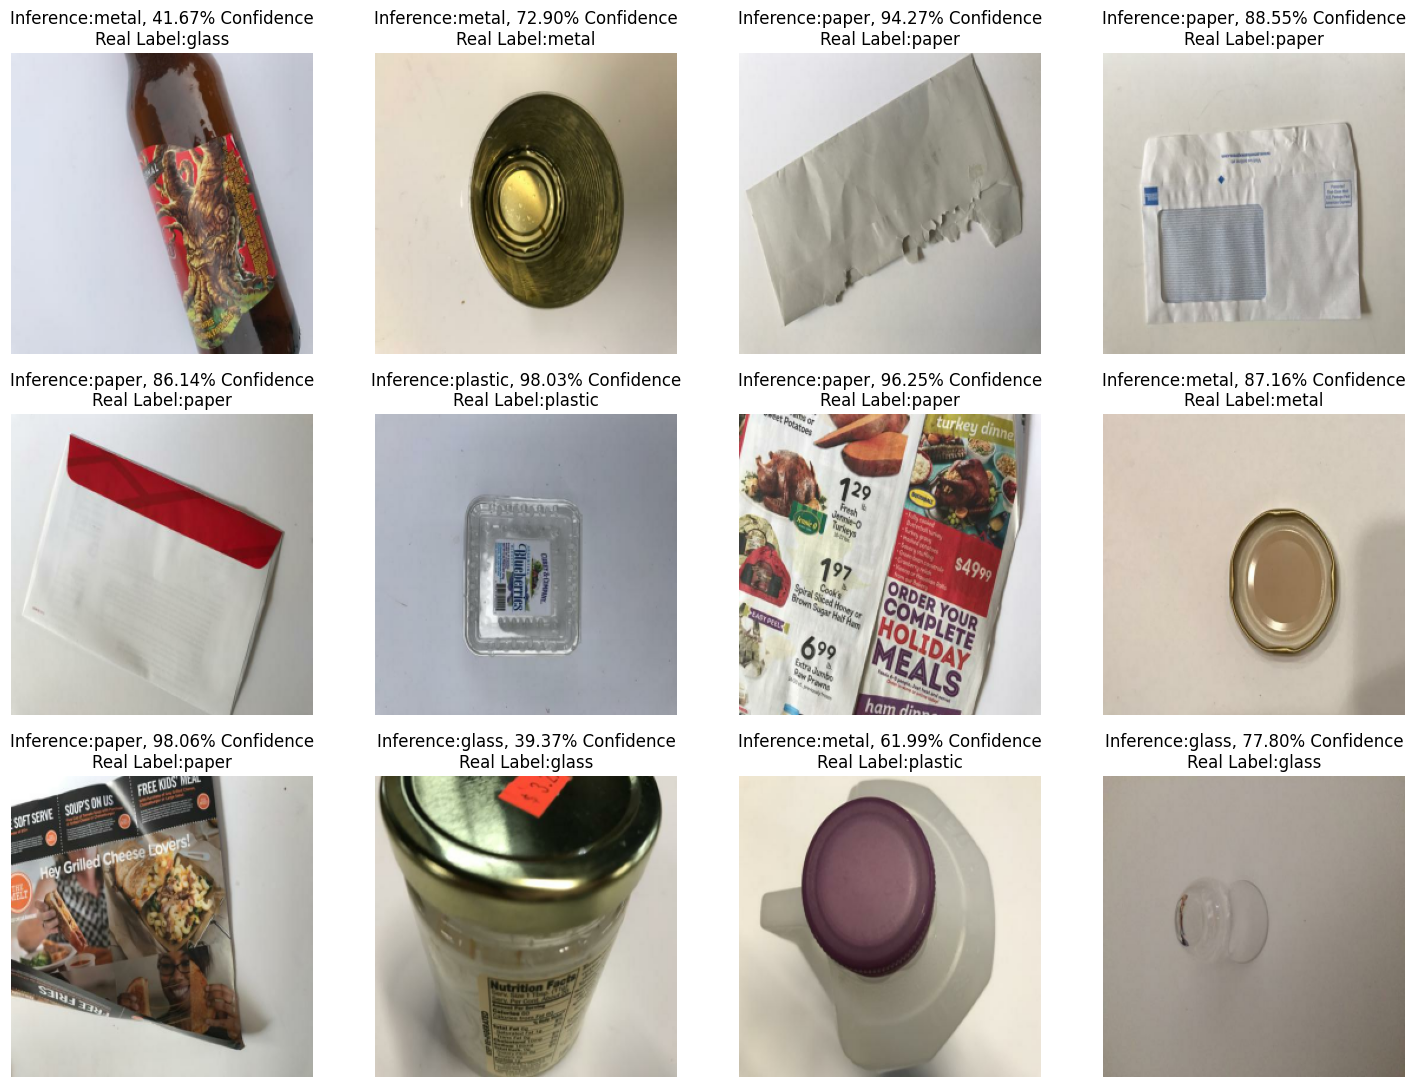

In [66]:
# get a batch from validation_ds to do some inference
image_batch, label_batch = validation_ds.as_numpy_iterator().next()

# inference
inference = model.predict_on_batch(image_batch)

# show imgs and labels
plt.figure(figsize=(18, 18))
for i in range(12):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title('Inference:{}, {:.2f}% Confidence\nReal Label:{}'
              .format(class_names[np.argmax(inference[i])], 100 * np.max(inference[i]), class_names[label_batch[i]]))
    plt.axis("off")

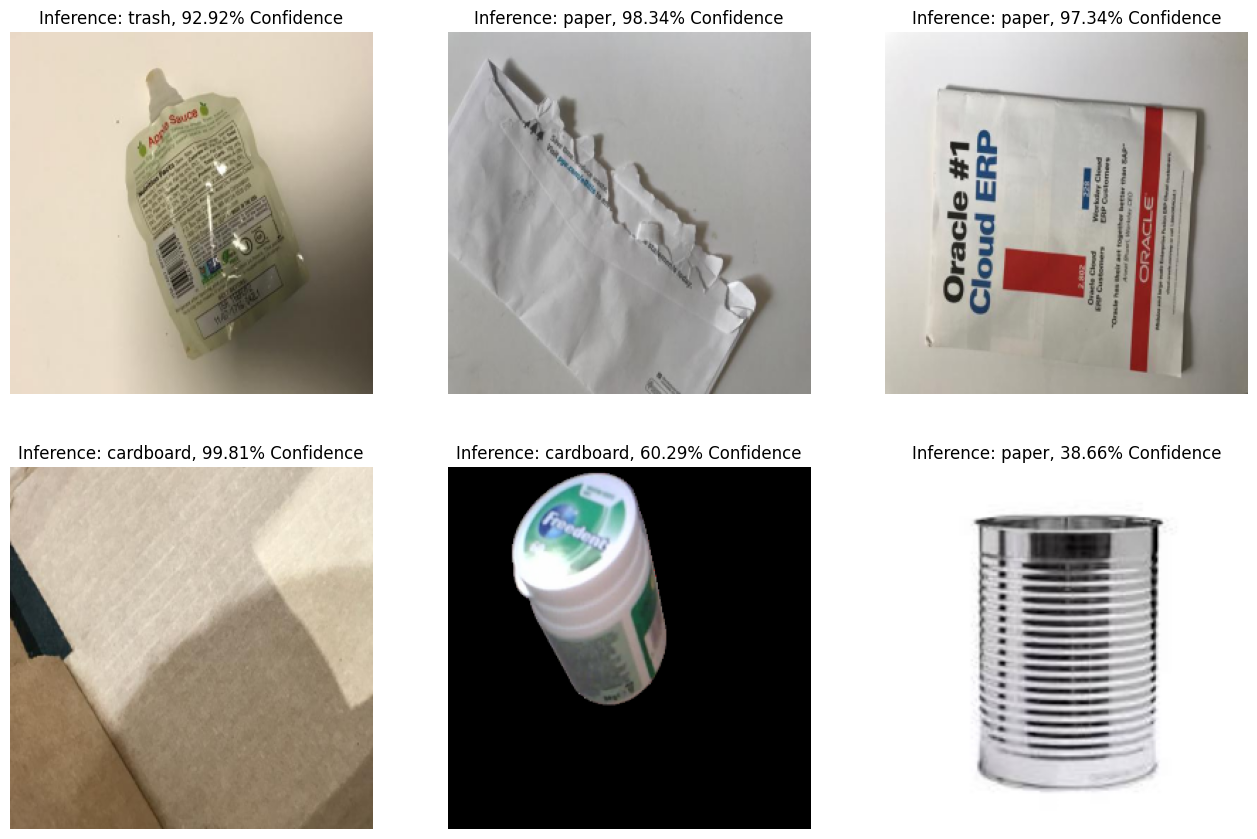

In [69]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Chemins des images locales
local_image_paths = [
    'test-images/trash1.jpg',
    'test-images/paper404.jpg',
    'test-images/paper403.jpg',
    'test-images/cardboard47.jpg',
    'test-images/test.png',
    'test-images/metal-can.jpeg'
]

# model = None
# model = tf.keras.models.load_model('alex.keras', compile=False)

# # Créer le dataset de test
test_ds = []
image_size = (256, 256)
for path in local_image_paths:
    img = cv2.imread(path)  # Charger l'image à partir du chemin local
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir en RGB (Matplotlib utilise RGB)
    img = cv2.resize(img, image_size)  # Redimensionner l'image
    test_ds.append(img)
test_ds = np.array(test_ds)

# Inférence
test_inference = model.predict_on_batch(test_ds)

# Afficher les images avec les prédictions
plt.figure(figsize=(16, 16))
for i in range(len(local_image_paths)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(test_ds[i].astype("uint8"))
    plt.title('Inference: {}, {:.2f}% Confidence'
              .format(class_names[np.argmax(test_inference[i])], 100 * np.max(test_inference[i])))
    plt.axis("off")

plt.show()

In [68]:
model.save('alex.keras')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 6)                 12294     
                                                                 
Total params: 23577094 (89.94 MB)
Trainable params: 14983174 (57.16 MB)
Non-trainable params: 8593920 (32.78 MB)
_________________________________________________________________
